# Needed Packages

The only package needed is found at [this github repo](https://github.com/dmolony3/Torch_to_TF/blob/master/ResNet/resnet.py), and it is used only in the first section to create a tensorflow ResNet34 model. I modified the resnet.py file in this package to remove the last Dense layer, since the definition of the model does not include the parameter 'include_top'.

# Tensorflow Implementation of FairFace Model in Resnet50

The FairFace model is trained on dataset that is balanced for race, age, and gender. This gives it increased performance in recognizing faces of minorities, as an overwhelming majority of widely available and widely used face datasets are disproportionately white, adult, males. For this experiment, we will be attempting to increase this performance further using a [Bayesian Dropout layer](https://arxiv.org/abs/1506.02142) before the fully connected layer. The FairFace model uses ResNet34 with 18 classes, with the first 7 being race, the next 2 being gender, and the final 9 being age. This final layer uses a Linear activation function, and then they take argmax of each of the three sets of classifications for the final predictions. To simplify this when porting the model over from pytorch to tensorflow keras, I have limited classification only to race, with 7 classes, and have used the softmax activation function.

In [1]:
from __future__ import print_function
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

This cell may not be necessary on google colab, however my GPU was having Resource Exhausted errors and configuring the GPU memory growth helped fix this.

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# This is the Base Model to work with

We will be using the ResNet34 model, same as FairFace. We will use code from [this github repo](https://github.com/dmolony3/Torch_to_TF) to copy the weights and biases from their pytorch model to my tensorflow. This ported model will still need training since it was designed for 18 classifiers and we are limiting it to 7.

In [3]:
import tensorflow as tf
from ResNet import resnet
import torchvision.models as models
import torch
import torch.nn as nn

# Original FairFace Model
torch_path = './FairFace/FairFace-master/fair_face_models/res34_fair_align_multi_7_20190809.pt'

# Defining the input tensor
inputs = tf.keras.Input((244, 244,3))

# Downloading a pretrained resnet34 model in pytorch
resnet_torch = models.resnet34(pretrained=True)

# We need to set the last layer to have 18 classes in order to load the weights and
#    biases of the FairFace model, and then we can change it to 7 classes.
resnet_torch.fc = nn.Linear(resnet_torch.fc.in_features, 18)
resnet_torch.load_state_dict(torch.load(torch_path,map_location=torch.device('cpu')))
resnet_torch.fc = nn.Linear(resnet_torch.fc.in_features, 7)

# Downloading a resnet34 model in tensorflow
resnet_tf = resnet.ResNet34(inputs)

base_model = tf.keras.Model(inputs, resnet_tf)
print(base_model.summary())


# place all variables in list
tf_layer_names = [layer.name for layer in base_model.layers]
torch_layer_names = []
for name, module in resnet_torch.named_modules():
    torch_layer_names.append(name)

tf_layer_names = [layer for layer in tf_layer_names if layer in torch_layer_names]
print(tf_layer_names)

# loop over all layers from Pytorch model also found in tensorflow model and port weights
for layer in tf_layer_names:
    if 'conv' in layer:
        tf_conv = base_model.get_layer(layer)
        weights = resnet_torch.state_dict()[layer+'.weight'].numpy()
        weights_list = [weights.transpose((2, 3, 1, 0))]
        if len(tf_conv.weights) == 2:
            bias = resnet_torch.state_dict()[layer+'.bias'].numpy()
            weights_list.append(bias)
        tf_conv.set_weights(weights_list)
    elif 'bn' in layer:
        tf_bn = base_model.get_layer(layer)
        gamma = resnet_torch.state_dict()[layer+'.weight'].numpy()
        beta = resnet_torch.state_dict()[layer+'.bias'].numpy()
        mean = resnet_torch.state_dict()[layer+'.running_mean'].numpy()
        var = resnet_torch.state_dict()[layer+'.running_var'].numpy()
        bn_list = [gamma, beta, mean, var]
        tf_bn.set_weights(bn_list)
    elif 'downsample.0' in layer:
        tf_downsample = base_model.get_layer(layer)
        weights = resnet_torch.state_dict()[layer+'.weight'].numpy()
        weights_list = [weights.transpose((2, 3, 1, 0))]
        if len(tf_downsample.weights) == 2:
            bias = resnet_torch.state_dict()[layer+'.bias'].numpy()
            weights_list.append(bias)
        tf_downsample.set_weights(weights_list)
    elif 'downsample.1' in layer:
        tf_downsample = base_model.get_layer(layer)
        gamma = resnet_torch.state_dict()[layer+'.weight'].numpy()
        beta = resnet_torch.state_dict()[layer+'.bias'].numpy()
        mean = resnet_torch.state_dict()[layer+'.running_mean'].numpy()
        var = resnet_torch.state_dict()[layer+'.running_var'].numpy()
        bn_list = [gamma, beta, mean, var] # [gamma, beta, mean, var]
        tf_downsample.set_weights(bn_list)
    elif 'fc' in layer:
        tf_fc = base_model.get_layer(layer)
        weights = resnet_torch.state_dict()[layer+'.weight'].numpy() 
        weights_list = [weights.transpose((1, 0))]
        if len(tf_fc.weights) == 2:
            bias = resnet_torch.state_dict()[layer+'.bias'].numpy()
            weights_list.append(bias)
        tf_fc.set_weights(weights_list)
    else:
        print('No parameters found for {}'.format(layer))



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
pad (ZeroPadding2D)             (None, 250, 250, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 122, 122, 64) 9408        pad[0][0]                        
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 122, 122, 64) 256         conv1[0][0]                      
_______________________________________________________________________________________

### Save Base Model

Now that we have the base model in tensorflow, we can save it as a backup and begin to create the augmented models we intend to test.

In [4]:
from tensorflow.keras import models as M

base_model.save('./models/base_model_tf/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/base_model_tf/assets


# Transfer Learning

To maintain the previous training of the original FairFace model, we will take advantage of the technique of transfer learning. Since this is a large model with nearly 100,000 images across training and validation, transfer learning will occur in 3 phases.

- Phase 1: Only the added classifying layers will be trainable.
- Phase 2: Only the ResNet34 layers without the added classifying layers will be trainable.
- Phase 3: All layers in the model will be trainable.

# Model 1 - No Modifications

This first model has no modifications to the original FairFace model, with the exception of the last layer having on 7 classes and using softmax activation. Since this applies to all three models, we will not make reference to this modification again. 

In [5]:
base_1 = M.load_model('./models/base_model_tf/')
fc_1 = tf.keras.layers.Dense(units=7, use_bias=True, activation='softmax', name='fc')(base_1.output)
model_1 = tf.keras.models.Model(inputs=base_1.input, outputs=fc_1)

In [6]:
for i, layer in enumerate(model_1.layers):
    if layer.name == 'fc':
        layer.trainable = True 
        print(f"Layer {i} (Trainable): {layer}")
    else:
        layer.trainable = False 
        print(f"Layer {i} (Non-trainable): {layer}")

Layer 0 (Non-trainable): <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb2d4a10630>
Layer 1 (Non-trainable): <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fb3406d6278>
Layer 2 (Non-trainable): <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb3c815d160>
Layer 3 (Non-trainable): <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb3c815d8d0>
Layer 4 (Non-trainable): <tensorflow.python.keras.layers.core.Activation object at 0x7fb360338080>
Layer 5 (Non-trainable): <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fb3603384a8>
Layer 6 (Non-trainable): <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb360338940>
Layer 7 (Non-trainable): <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb360338f28>
Layer 8 (Non-trainable): <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb360339668>
Layer 9 (Non-trainable)

In [7]:
# Now we can prepaire our model for training

model_1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model_1.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
pad (ZeroPadding2D)             (None, 250, 250, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 122, 122, 64) 9408        pad[0][0]                        
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 122, 122, 64) 256         conv1[0][0]                      
_______________________________________________________________________________________

# Model 2 - Add Dropout Layer

This second augmented model has a traditional Dropout layer before the classifier, with a Dropout rate=0.5. This augmented model is part of the experiment to see if there is significant change of performance not just between the control and the Dropout as a Bayesian Approximation, but also to show that changes in performance, if any, are in fact attributed to Bayesian Approximation or if it was just the addition of a Dropout layer that changed performance.

In [9]:
base_2 = M.load_model('./models/base_model_tf/')
dropout_1 = tf.keras.layers.Dropout(0.5,name='AddedDropout')(base_2.output)
fc_2 = tf.keras.layers.Dense(units=7, use_bias=True, activation='softmax', name='fc')(dropout_1)
model_2 = tf.keras.models.Model(inputs=base_2.input, outputs=fc_2)

In [10]:
for i, layer in enumerate(model_2.layers):
    if layer.name == 'fc':
        layer.trainable = True 
        print(f"Layer {i} (Trainable): {layer}")
    elif layer.name == 'AddedDropout':
        layer.trainable = True 
        print(f"Layer {i} (Trainable): {layer}")
    else:
        layer.trainable = False 
        print(f"Layer {i} (Non-trainable): {layer}")

Layer 0 (Non-trainable): <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb2a273f860>
Layer 1 (Non-trainable): <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fb2a273fc18>
Layer 2 (Non-trainable): <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb2a274c3c8>
Layer 3 (Non-trainable): <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb2a274cac8>
Layer 4 (Non-trainable): <tensorflow.python.keras.layers.core.Activation object at 0x7fb2a27542b0>
Layer 5 (Non-trainable): <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fb2a27546d8>
Layer 6 (Non-trainable): <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb2a2754b70>
Layer 7 (Non-trainable): <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb2a2759198>
Layer 8 (Non-trainable): <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb2a2759898>
Layer 9 (Non-trainable)

In [11]:
# Now we can prepaire our model for training

model_2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model_2.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
pad (ZeroPadding2D)             (None, 250, 250, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 122, 122, 64) 9408        pad[0][0]                        
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 122, 122, 64) 256         conv1[0][0]                      
_______________________________________________________________________________________

# Model 3 - Add Bayesian Dropout Layer

Lastly, this third model uses Dropout as a Bayesian Approximation right before the classifier, to measure if there is any significant change in performance if

In [13]:
import tensorflow as tf
from tensorflow.python.ops.distributions.bernoulli import Bernoulli

class VariationalDense:
    """Variational Dense Layer Class"""
    def __init__(self, n_in, n_out, model_prob, model_lam):
        self.model_prob = model_prob
        self.model_lam = model_lam
        self.model_bern = Bernoulli(probs=self.model_prob, dtype=tf.float32)
        self.model_M = tf.Variable(tf.random.truncated_normal([n_in, n_out], stddev=0.01))
        self.model_m = tf.Variable(tf.zeros([n_out]))
        self.model_W = tf.matmul(
            tf.compat.v1.diag(self.model_bern.sample((n_in, ))), self.model_M
        )

    def __call__(self, X, activation=tf.identity):
        output = activation(tf.matmul(X, self.model_W) + self.model_m)
        if self.model_M.shape[1] == 1:
            output = tf.squeeze(output)
        return output

    @property
    def regularization(self):
        return self.model_lam * (
            self.model_prob * tf.reduce_sum(tf.square(self.model_M)) +
            tf.reduce_sum(tf.square(self.model_m))
        )


In [14]:
base_3 = M.load_model('./models/base_model_tf/')

model_prob = 0.9
model_lam = 1e-2

dropout_2 = VariationalDense(n_in=512,n_out=512,model_lam=model_lam,model_prob=model_prob)(base_3.output)
fc_3 = tf.keras.layers.Dense(units=7, use_bias=True, activation='softmax', name='fc')(dropout_2)
model_3 = tf.keras.models.Model(inputs=base_3.input, outputs=fc_3)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [15]:
for i, layer in enumerate(model_3.layers):
    if layer.name == 'fc':
        layer.trainable = True 
        print(f"Layer {i} (Trainable): {layer}")
    elif layer.name == 'tf_op_layer_MatMul_4':
        layer.trainable = True 
        print(f"Layer {i} (Trainable): {layer}")
    elif layer.name == 'tf_op_layer_AddV2_4':
        layer.trainable = True 
        print(f"Layer {i} (Trainable): {layer}")
    elif layer.name == 'tf_op_layer_Identity_4':
        layer.trainable = True 
        print(f"Layer {i} (Trainable): {layer}")
    else:
        layer.trainable = False 
        print(f"Layer {i} (Non-trainable): {layer}")

Layer 0 (Non-trainable): <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb29bf802b0>
Layer 1 (Non-trainable): <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fb29bf80668>
Layer 2 (Non-trainable): <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb29bf80dd8>
Layer 3 (Non-trainable): <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb29bf8b588>
Layer 4 (Non-trainable): <tensorflow.python.keras.layers.core.Activation object at 0x7fb29bf8bcf8>
Layer 5 (Non-trainable): <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fb29bf93160>
Layer 6 (Non-trainable): <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb29bf935f8>
Layer 7 (Non-trainable): <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb29bf93be0>
Layer 8 (Non-trainable): <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb29bf99320>
Layer 9 (Non-trainable)

In [16]:
# Now we can prepaire our model for training

model_3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model_3.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
pad (ZeroPadding2D)             (None, 250, 250, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 122, 122, 64) 9408        pad[0][0]                        
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 122, 122, 64) 256         conv1[0][0]                      
_______________________________________________________________________________________

# Preparing Input Data

In [18]:
main_dir = './FairFace/fairface-img-margin025-trainval/'

### Cleaning Data First

In [19]:
# Remove corrupted images from data.

from PIL import Image
import piexif

def is_valid_jpg(filename):
    try:
        i=Image.open(filename)
        return i.format =='JPEG'
    except IOError:
        return False

def remove_corrupted_images_from_folder(cdir, verbose=False):
    total=0
    counter = 0
    for subdir, dirs, files in os.walk(cdir):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".jpg") or filepath.endswith(".png"):
                total += 1
                if not is_valid_jpg(filepath):
                    counter +=1
                    os.remove(filepath)
                    if (verbose):
                        print(f"--Removed file ${filepath}")
    print(f"{counter} jpeg files removed out of {total} in folder {cdir}")

train_dir = main_dir + 'train/'
val_dir = main_dir + 'val/'


remove_corrupted_images_from_folder(train_dir,verbose=True) 
remove_corrupted_images_from_folder(val_dir,verbose=True)

0 jpeg files removed out of 86744 in folder ./FairFace/fairface-img-margin025-trainval/train/
0 jpeg files removed out of 10954 in folder ./FairFace/fairface-img-margin025-trainval/val/


### Splitting Data By Race

FairFace model predicts race, age, and gender. We will only focus on race for our model. FairFace provides a csv with all the locations and labels for their pictures, so we will be manipulating this csv to only focus on the Race label and move the images to their own subdirectories in /train and /val for the image datagen.

In [20]:
import pandas as pd

train_labels = pd.read_csv(main_dir + 'fairface_label_train.csv')
val_labels = pd.read_csv(main_dir + 'fairface_label_val.csv')

races_list = list(train_labels['race'].unique())

train_labels['copy_to'] = train_labels.apply(lambda x: 'train/' + x['race'] + '/', axis=1)
val_labels['copy_to'] = val_labels.apply(lambda x: 'val/' + x['race'] + '/', axis=1)

train_labels = train_labels[['file','copy_to']]
val_labels = val_labels[['file','copy_to']]

In [21]:
train_labels.head(5)

,file,copy_to
0,train/1.jpg,train/East Asian/
1,train/2.jpg,train/Indian/
2,train/3.jpg,train/Black/
3,train/4.jpg,train/Indian/
4,train/5.jpg,train/Indian/


In [22]:
val_labels.head(5)

,file,copy_to
0,val/1.jpg,val/East Asian/
1,val/2.jpg,val/East Asian/
2,val/3.jpg,val/White/
3,val/4.jpg,val/Latino_Hispanic/
4,val/5.jpg,val/Southeast Asian/


In [ ]:
import shutil

for race in races_list:
    for folder in ['train/','val/']:
        os.mkdir(main_dir + folder + race)

for idx, row in train_labels.iterrows():
    shutil.move(main_dir + row['file'], main_dir + row['copy_to'])
    
for idx, row in val_labels.iterrows():
    shutil.move(main_dir + row['file'], main_dir + row['copy_to'])

### Image Data Generators

In [85]:
img_datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            horizontal_flip=True) 


train_generator = img_datagen.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  batch_size=5,
                                                  class_mode='categorical')

validation_generator = img_datagen.flow_from_directory(val_dir,
                                                       target_size=(224,224),
                                                       batch_size=5,
                                                       class_mode='categorical')



step_size_train = train_generator.n / train_generator.batch_size
step_size_valid = validation_generator.n / validation_generator.batch_size

Found 86744 images belonging to 7 classes.
Found 10954 images belonging to 7 classes.


# Training and Testing

### Early Stopping and Model Callback

In [24]:
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=10,
                   min_delta=0.01)

In [25]:
model_1_checkpoint_filepath = main_dir + 'checkpoints/model_1'
model_1_checkpoint_callback = ModelCheckpoint(filepath=model_1_checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True)

In [26]:
model_2_checkpoint_filepath = main_dir + 'checkpoints/model_2'
model_2_checkpoint_callback = ModelCheckpoint(filepath=model_2_checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True)

In [27]:
model_3_checkpoint_filepath = main_dir + 'checkpoints/model_3'
model_3_checkpoint_callback = ModelCheckpoint(filepath=model_3_checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True)

### Training all 3 models:

In [28]:
epochs = 30

In [29]:
hist1 = model_1.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=step_size_valid,
                    callbacks=[es,model_1_checkpoint_callback])

Epoch 1/30
17349/17348 [==============================] - 698s 40ms/step - loss: 2.5499 - accuracy: 0.2125 - val_loss: 2.6367 - val_accuracy: 0.2269
Epoch 2/30
17349/17348 [==============================] - 698s 40ms/step - loss: 2.4767 - accuracy: 0.2306 - val_loss: 2.5170 - val_accuracy: 0.2049
Epoch 3/30
17349/17348 [==============================] - 698s 40ms/step - loss: 2.4456 - accuracy: 0.2370 - val_loss: 3.0768 - val_accuracy: 0.2102
Epoch 4/30
17349/17348 [==============================] - 696s 40ms/step - loss: 2.4361 - accuracy: 0.2423 - val_loss: 3.8957 - val_accuracy: 0.2016
Epoch 5/30
17349/17348 [==============================] - 698s 40ms/step - loss: 2.4437 - accuracy: 0.2421 - val_loss: 2.2769 - val_accuracy: 0.2676
Epoch 6/30
17349/17348 [==============================] - 699s 40ms/step - loss: 2.4196 - accuracy: 0.2453 - val_loss: 2.4870 - val_accuracy: 0.2930
Epoch 7/30
17349/17348 [==============================] - 700s 40ms/step - loss: 2.4186 - accuracy: 0.2478

In [30]:
hist2 = model_2.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=step_size_valid,
                    callbacks=[es,model_2_checkpoint_callback])

Epoch 1/30
17349/17348 [==============================] - 666s 38ms/step - loss: 3.7599 - accuracy: 0.1778 - val_loss: 2.6529 - val_accuracy: 0.2066
Epoch 2/30
17349/17348 [==============================] - 664s 38ms/step - loss: 3.2562 - accuracy: 0.1819 - val_loss: 3.1150 - val_accuracy: 0.2195
Epoch 3/30
17349/17348 [==============================] - 665s 38ms/step - loss: 3.2346 - accuracy: 0.1808 - val_loss: 2.2023 - val_accuracy: 0.2336
Epoch 4/30
17349/17348 [==============================] - 664s 38ms/step - loss: 3.2316 - accuracy: 0.1815 - val_loss: 3.1716 - val_accuracy: 0.1435
Epoch 5/30
17349/17348 [==============================] - 664s 38ms/step - loss: 3.2504 - accuracy: 0.1819 - val_loss: 3.2331 - val_accuracy: 0.1658
Epoch 6/30
17349/17348 [==============================] - 664s 38ms/step - loss: 3.2584 - accuracy: 0.1818 - val_loss: 2.7294 - val_accuracy: 0.2022
Epoch 7/30
17349/17348 [==============================] - 664s 38ms/step - loss: 3.2229 - accuracy: 0.1828

In [31]:
hist3 = model_3.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=step_size_valid,
                    callbacks=[es,model_3_checkpoint_callback])

Epoch 1/30
17349/17348 [==============================] - 667s 38ms/step - loss: 2.0040 - accuracy: 0.2288 - val_loss: 2.0707 - val_accuracy: 0.2437
Epoch 2/30
17349/17348 [==============================] - 665s 38ms/step - loss: 1.9761 - accuracy: 0.2414 - val_loss: 2.2442 - val_accuracy: 0.2535
Epoch 3/30
17349/17348 [==============================] - 665s 38ms/step - loss: 1.9627 - accuracy: 0.2450 - val_loss: 1.9842 - val_accuracy: 0.2904
Epoch 4/30
17349/17348 [==============================] - 665s 38ms/step - loss: 1.9582 - accuracy: 0.2507 - val_loss: 1.9157 - val_accuracy: 0.2381
Epoch 5/30
17349/17348 [==============================] - 664s 38ms/step - loss: 1.9539 - accuracy: 0.2552 - val_loss: 1.9458 - val_accuracy: 0.2552
Epoch 6/30
17349/17348 [==============================] - 664s 38ms/step - loss: 1.9434 - accuracy: 0.2565 - val_loss: 1.8819 - val_accuracy: 0.2705
Epoch 7/30
17349/17348 [==============================] - 664s 38ms/step - loss: 1.9478 - accuracy: 0.2586

# Evaluating Initial Results

In [40]:
def plot_results(hist,title):
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.plot(hist.history['loss'],label='train loss')
    plt.plot(hist.history['val_loss'],label='val loss')
    plt.title(title + ' Loss')
    plt.legend()
    plt.subplot(2,2,2)
    plt.plot(hist.history['accuracy'],label='train accuracy')
    plt.plot(hist.history['val_accuracy'],label='val accuracy')
    plt.title(title + ' Accuracy')
    plt.legend()
    plt.show()

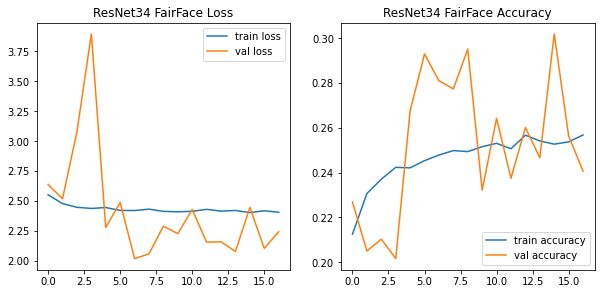

In [41]:
plot_results(hist1, 'ResNet34 FairFace')

In [94]:
print('Model 1 accuracy: {:2.2%}'.format(0.2406))
print('Model 1 loss:\t{:2.2%}'.format(2.2415))

Model 1 accuracy: 24.06%
Model 1 loss:	224.15%


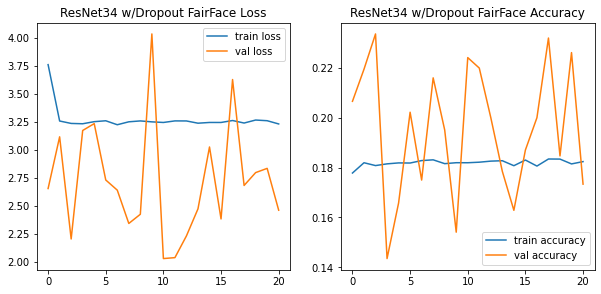

In [42]:
plot_results(hist2, 'ResNet34 w/Dropout FairFace')

In [95]:
print('Model 2 accuracy: {:2.2%}'.format(0.1734))
print('Model 2 loss:\t{:2.2%}'.format(2.4594))

Model 2 accuracy: 17.34%
Model 2 loss:	245.94%


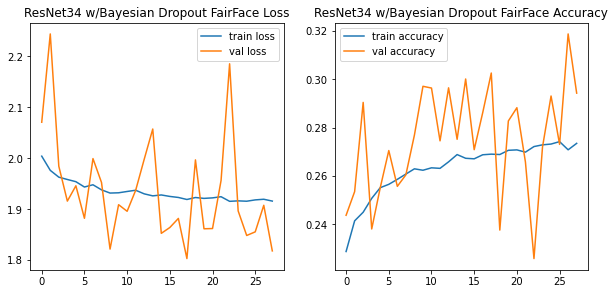

In [43]:
plot_results(hist3, 'ResNet34 w/Bayesian Dropout FairFace')

In [96]:
print('Model 3 accuracy: {:2.2%}'.format(0.2942))
print('Model 3 loss:\t{:2.2%}'.format(1.8178))

Model 3 accuracy: 29.42%
Model 3 loss:	181.78%


#### We can see that while there is an improvement in models 1 and 3, a regular dropout layer has a negative impact on model 2's loss and accuracy. Now that the classifier level is trained, we can save these models and set all parameters to trainable, to see if this can improve accuracy. Currently, the accuracy even on training is still very low and the loss on training still very high.

In [44]:
model_1.save('./models/model_1/')
model_2.save('./models/model_2/')
model_3.save('./models/model_3/')

INFO:tensorflow:Assets written to: ./models/model_1/assets
INFO:tensorflow:Assets written to: ./models/model_2/assets
INFO:tensorflow:Assets written to: ./models/model_3/assets


In [62]:
model_1 = M.load_model('./models/model_1/')
model_2 = M.load_model('./models/model_2/')
model_3 = M.load_model('./models/model_3/')

In [63]:
for i, layer in enumerate(model_1.layers):
    if layer.name == 'fc':
        layer.trainable = False 
#         print(f"Layer {i} (Trainable): {layer}")
    else:
        layer.trainable = True 
#         print(f"Layer {i} (Non-trainable): {layer}")

In [64]:
for i, layer in enumerate(model_2.layers):
    if layer.name == 'fc':
        layer.trainable = False
    elif layer.name == 'AddedDropout':
        layer.trainable = False
#         print(f"Layer {i} (Trainable): {layer}")
    else:
        layer.trainable = True
#         print(f"Layer {i} (Non-trainable): {layer}")

In [65]:
for i, layer in enumerate(model_3.layers):
    if layer.name == 'fc':
        layer.trainable = False
#         print(f"Layer {i} (Trainable): {layer}")
    elif layer.name == 'tf_op_layer_MatMul_4':
        layer.trainable = False
#         print(f"Layer {i} (Trainable): {layer}")
    elif layer.name == 'tf_op_layer_AddV2_4':
        layer.trainable = False
#         print(f"Layer {i} (Trainable): {layer}")
    elif layer.name == 'tf_op_layer_Identity_4':
        layer.trainable = False
#         print(f"Layer {i} (Trainable): {layer}")
    else:
        layer.trainable = True
#         print(f"Layer {i} (Non-trainable): {layer}")

# Training again, with hidden layers trainable.

In [66]:
epochs = 20

In [67]:
hist1_1 = model_1.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=step_size_valid,
                    callbacks=[es,model_1_checkpoint_callback])

Epoch 1/20
17349/17348 [==============================] - 1279s 74ms/step - loss: 2.0084 - accuracy: 0.1975 - val_loss: 1.9304 - val_accuracy: 0.2376
Epoch 2/20
17349/17348 [==============================] - 1277s 74ms/step - loss: 1.9053 - accuracy: 0.2372 - val_loss: 6.9022 - val_accuracy: 0.2387
Epoch 3/20
17349/17348 [==============================] - 1277s 74ms/step - loss: 1.7178 - accuracy: 0.3266 - val_loss: 12.0381 - val_accuracy: 0.2916
Epoch 4/20
17349/17348 [==============================] - 1277s 74ms/step - loss: 1.4336 - accuracy: 0.4433 - val_loss: 1.6628 - val_accuracy: 0.4619
Epoch 5/20
17349/17348 [==============================] - 1277s 74ms/step - loss: 1.2703 - accuracy: 0.5083 - val_loss: 1.2289 - val_accuracy: 0.5278
Epoch 6/20
17349/17348 [==============================] - 1276s 74ms/step - loss: 1.1771 - accuracy: 0.5453 - val_loss: 1.1562 - val_accuracy: 0.5552
Epoch 7/20
17349/17348 [==============================] - 1276s 74ms/step - loss: 1.1183 - accuracy

In [71]:
hist2_1 = model_2.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=step_size_valid,
                    callbacks=[es,model_2_checkpoint_callback])

Epoch 1/20
17349/17348 [==============================] - 1694s 98ms/step - loss: 1.7549 - accuracy: 0.3129 - val_loss: 1.6561 - val_accuracy: 0.3589
Epoch 2/20
17349/17348 [==============================] - 1709s 99ms/step - loss: 1.5675 - accuracy: 0.3925 - val_loss: 2.7422 - val_accuracy: 0.4149
Epoch 3/20
17349/17348 [==============================] - 1688s 97ms/step - loss: 1.4006 - accuracy: 0.4610 - val_loss: 1.2999 - val_accuracy: 0.5029
Epoch 4/20
17349/17348 [==============================] - 1407s 81ms/step - loss: 1.2860 - accuracy: 0.5038 - val_loss: 1.2708 - val_accuracy: 0.5121
Epoch 5/20
17349/17348 [==============================] - 1291s 74ms/step - loss: 1.2174 - accuracy: 0.5323 - val_loss: 1.2177 - val_accuracy: 0.5359
Epoch 6/20
17349/17348 [==============================] - 1280s 74ms/step - loss: 1.1714 - accuracy: 0.5509 - val_loss: 1.2448 - val_accuracy: 0.5303
Epoch 7/20
17349/17348 [==============================] - 1280s 74ms/step - loss: 1.1280 - accuracy:

In [72]:
hist3_1 = model_3.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=step_size_valid,
                    callbacks=[es,model_3_checkpoint_callback])

Epoch 1/20
17349/17348 [==============================] - 1269s 73ms/step - loss: 1.8572 - accuracy: 0.2577 - val_loss: 1.8583 - val_accuracy: 0.3276
Epoch 2/20
17349/17348 [==============================] - 1270s 73ms/step - loss: 1.5121 - accuracy: 0.4140 - val_loss: 1.5242 - val_accuracy: 0.4410
Epoch 3/20
17349/17348 [==============================] - 1278s 74ms/step - loss: 1.2886 - accuracy: 0.5011 - val_loss: 1.2741 - val_accuracy: 0.5307
Epoch 4/20
17349/17348 [==============================] - 1277s 74ms/step - loss: 1.1782 - accuracy: 0.5442 - val_loss: 1.1588 - val_accuracy: 0.5550
Epoch 5/20
17349/17348 [==============================] - 1277s 74ms/step - loss: 1.1133 - accuracy: 0.5711 - val_loss: 1.0819 - val_accuracy: 0.5844
Epoch 6/20
17349/17348 [==============================] - 1278s 74ms/step - loss: 1.0659 - accuracy: 0.5887 - val_loss: 1.0648 - val_accuracy: 0.5889
Epoch 7/20
17349/17348 [==============================] - 1277s 74ms/step - loss: 1.0299 - accuracy:

### Lets see the results of this training, where everything but the last layers were trainable.

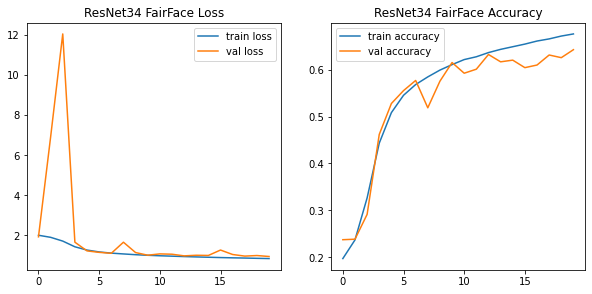

In [74]:
plot_results(hist1_1, 'ResNet34 FairFace')

In [97]:
print('Model 1 accuracy: {:2.2%}'.format(0.6424))
print('Model 1 loss:\t{:2.2%}'.format(0.9498))

Model 1 accuracy: 64.24%
Model 1 loss:	94.98%


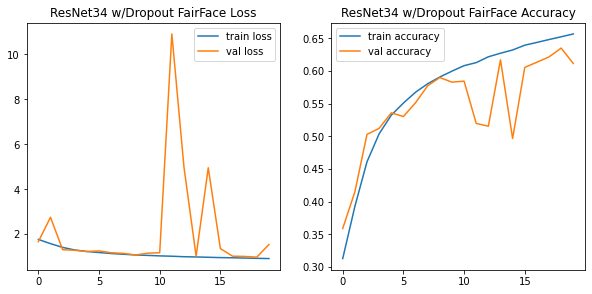

In [77]:
plot_results(hist2_1, 'ResNet34 w/Dropout FairFace')

In [98]:
print('Model 2 accuracy: {:2.2%}'.format(0.6115))
print('Model 2 loss:\t{:2.2%}'.format(1.5285))

Model 2 accuracy: 61.15%
Model 2 loss:	152.85%


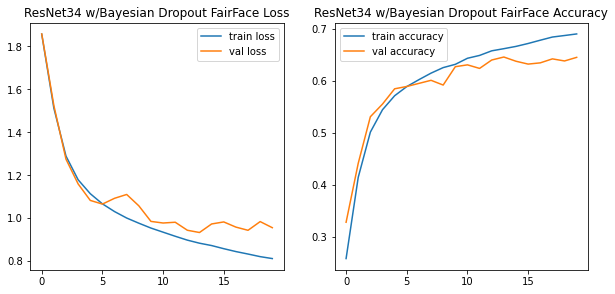

In [79]:
plot_results(hist3_1, 'ResNet34 w/Bayesian Dropout FairFace')

In [99]:
print('Model 3 accuracy: {:2.2%}'.format(0.6450))
print('Model 3 loss:\t{:2.2%}'.format(0.9547))

Model 3 accuracy: 64.50%
Model 3 loss:	95.47%


#### There is marked improvement in the models, but it seems as though much more training is needed. None of them utilized any early stopping, and accuracy gains have not plateaued. I will train one final time, with all layers trainable.

# Training one last time, with all layers trainable.

In [81]:
model_1.save('./models/model_1_1/')
model_2.save('./models/model_2_1/')
model_3.save('./models/model_3_1/')

INFO:tensorflow:Assets written to: ./models/model_1_1/assets
INFO:tensorflow:Assets written to: ./models/model_2_1/assets
INFO:tensorflow:Assets written to: ./models/model_3_1/assets


In [82]:
for i, layer in enumerate(model_1.layers):
    layer.trainable = True 
for i, layer in enumerate(model_2.layers):
    layer.trainable = True 
for i, layer in enumerate(model_3.layers):
    layer.trainable = True 

In [87]:
epochs = 12

In [88]:
hist1_2 = model_1.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=step_size_valid,
                    callbacks=[es,model_1_checkpoint_callback])

Epoch 1/12
17349/17348 [==============================] - 1220s 70ms/step - loss: 0.7930 - accuracy: 0.6977 - val_loss: 0.9545 - val_accuracy: 0.6498
Epoch 2/12
17349/17348 [==============================] - 1221s 70ms/step - loss: 0.7170 - accuracy: 0.7273 - val_loss: 0.9133 - val_accuracy: 0.6604
Epoch 3/12
17349/17348 [==============================] - 1220s 70ms/step - loss: 0.6404 - accuracy: 0.7566 - val_loss: 0.9906 - val_accuracy: 0.6449
Epoch 4/12
17349/17348 [==============================] - 1220s 70ms/step - loss: 0.5626 - accuracy: 0.7873 - val_loss: 1.0037 - val_accuracy: 0.6592
Epoch 5/12
17349/17348 [==============================] - 1220s 70ms/step - loss: 0.4871 - accuracy: 0.8171 - val_loss: 1.1507 - val_accuracy: 0.6410
Epoch 6/12
17349/17348 [==============================] - 1227s 71ms/step - loss: 0.4148 - accuracy: 0.8431 - val_loss: 1.2144 - val_accuracy: 0.6321
Epoch 7/12
17349/17348 [==============================] - 1230s 71ms/step - loss: 0.3509 - accuracy:

In [89]:
hist2_2 = model_2.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=step_size_valid,
                    callbacks=[es,model_2_checkpoint_callback])

Epoch 1/12
17349/17348 [==============================] - 1222s 70ms/step - loss: 0.8543 - accuracy: 0.6761 - val_loss: 0.9546 - val_accuracy: 0.6452
Epoch 2/12
17349/17348 [==============================] - 1222s 70ms/step - loss: 0.7961 - accuracy: 0.6986 - val_loss: 12.2512 - val_accuracy: 0.5111
Epoch 3/12
17349/17348 [==============================] - 1221s 70ms/step - loss: 0.7430 - accuracy: 0.7182 - val_loss: 3.8576 - val_accuracy: 0.5975
Epoch 4/12
17349/17348 [==============================] - 1222s 70ms/step - loss: 0.6943 - accuracy: 0.7382 - val_loss: 1.0189 - val_accuracy: 0.6376
Epoch 5/12
17349/17348 [==============================] - 1221s 70ms/step - loss: 0.6362 - accuracy: 0.7600 - val_loss: 5.8862 - val_accuracy: 0.5375
Epoch 6/12
17349/17348 [==============================] - 1228s 71ms/step - loss: 0.5816 - accuracy: 0.7830 - val_loss: 1.4461 - val_accuracy: 0.6276
Epoch 7/12
17349/17348 [==============================] - 1227s 71ms/step - loss: 0.5279 - accuracy

In [90]:
hist3_2 = model_3.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=step_size_valid,
                    callbacks=[es,model_3_checkpoint_callback])

Epoch 1/12
17349/17348 [==============================] - 1227s 71ms/step - loss: 0.7554 - accuracy: 0.7126 - val_loss: 0.9149 - val_accuracy: 0.6582
Epoch 2/12
17349/17348 [==============================] - 1230s 71ms/step - loss: 0.6671 - accuracy: 0.7462 - val_loss: 0.9528 - val_accuracy: 0.6628
Epoch 3/12
17349/17348 [==============================] - 1229s 71ms/step - loss: 0.5792 - accuracy: 0.7825 - val_loss: 1.1258 - val_accuracy: 0.6473
Epoch 4/12
17349/17348 [==============================] - 1229s 71ms/step - loss: 0.4920 - accuracy: 0.8146 - val_loss: 1.1692 - val_accuracy: 0.6395
Epoch 5/12
17349/17348 [==============================] - 1229s 71ms/step - loss: 0.4111 - accuracy: 0.8477 - val_loss: 1.1158 - val_accuracy: 0.6420
Epoch 6/12
17349/17348 [==============================] - 1229s 71ms/step - loss: 0.3381 - accuracy: 0.8740 - val_loss: 1.3091 - val_accuracy: 0.6366
Epoch 7/12
17349/17348 [==============================] - 1230s 71ms/step - loss: 0.2808 - accuracy:

### Finally, lets visualise the results of the training where all layers were trainable.

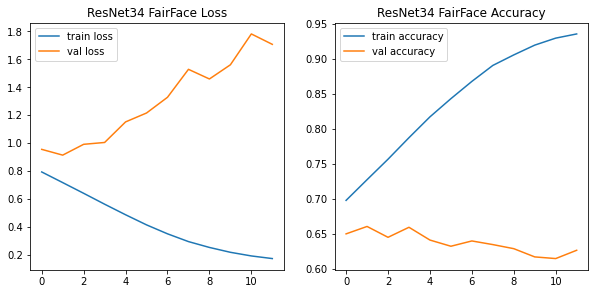

In [91]:
plot_results(hist1_2, 'ResNet34 FairFace')

In [100]:
print('Model 1 accuracy: {:2.2%}'.format(0.6263))
print('Model 1 loss:\t{:2.2%}'.format(1.7050))

Model 1 accuracy: 62.63%
Model 1 loss:	170.50%


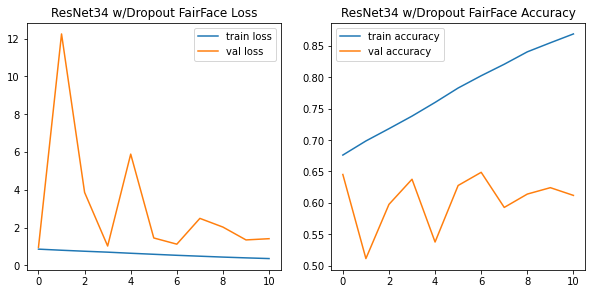

In [92]:
plot_results(hist2_2, 'ResNet34 w/Dropout FairFace')

In [101]:
print('Model 2 accuracy: {:2.2%}'.format(0.6118))
print('Model 2 loss:\t{:2.2%}'.format(1.4075))

Model 2 accuracy: 61.18%
Model 2 loss:	140.75%


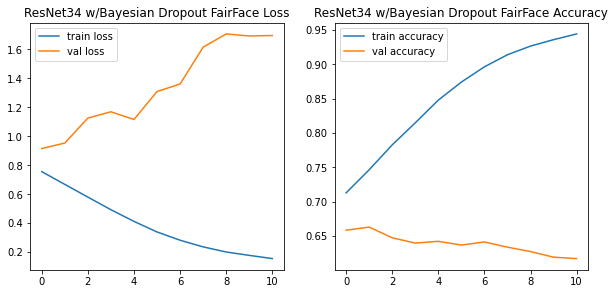

In [93]:
plot_results(hist3_2, 'ResNet34 w/Bayesian Dropout FairFace')

In [102]:
print('Model 3 accuracy: {:2.2%}'.format(0.6169))
print('Model 3 loss:\t{:2.2%}'.format(1.6968))

Model 3 accuracy: 61.69%
Model 3 loss:	169.68%


In [103]:
model_1.save('./models/model_1_2/')
model_2.save('./models/model_2_2/')
model_3.save('./models/model_3_2/')

INFO:tensorflow:Assets written to: ./models/model_1_2/assets
INFO:tensorflow:Assets written to: ./models/model_2_2/assets
INFO:tensorflow:Assets written to: ./models/model_3_2/assets


# Conclusion

As we can see by the graphs for the final training iteration, there is definitely an over fitting to the training data. I suspect there were too many epochs, in total, across all 3 training iterations. However, we did see in the second iteration that the accuracy for both training and validation improved, and we saw that the loss for both the training and the validation decreased. Additionally, we saw that the addition of the variational dense layer (Dropout as a Bayesian Approximation) did have a marked improvement in accuracy when comepared to the control model (model 1)